# **FINE TUNING FASTER RCNN USING PYTORCH**

Hello Everyone!

In this Notebook we can fine tune a Faster RCNN on the bollworm dataset. If you want to brush up about what is Faster RCNN, [here's](https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) an awesome medium article on the same.

The code is inspired by the Pytorch docs tutorial [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


## Installs and Imports

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.patches as patches
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from torchvision import transforms
DIR_INPUT = '/kaggle/input/resized-images/images_resized'
DIR_TRAIN = '/kaggle/input/resized-images/images_resized'
DIR_TEST = f'{DIR_INPUT}/test'

In [3]:
train_df = pd.read_csv('/kaggle/input/box-resized2/box_resized.csv')
test=pd.read_csv('/kaggle/input/train-csv/Test.csv')
train_df

,image_id,worm_type,min_X,min_Y,max_X,max_Y,weight,height,min_X_res,min_Y_res,max_X_res,max_Y_res
0,id_8ada71185e18dc8838b4925b.jpg,1,2377.970000,156.770000,2478.890000,297.860000,3072,3072,185.778906,12.247656,193.663281,23.270313
1,id_8ada71185e18dc8838b4925b.jpg,1,715.390000,1221.460000,939.820000,1319.680000,3072,3072,55.889844,95.426563,73.423438,103.100000
2,id_8ada71185e18dc8838b4925b.jpg,2,1129.730000,1558.060000,1559.700000,1966.300000,3072,3072,88.260156,121.723438,121.851562,153.617188
3,id_bc86d3cfd0c0463fa5cae33e.jpg,2,1743.676282,1537.210067,2090.216400,1799.814857,4000,3000,104.620577,122.976805,125.412984,143.985189
4,id_bc86d3cfd0c0463fa5cae33e.jpg,2,2162.137567,1676.304250,2342.256859,1952.269926,4000,3000,129.728254,134.104340,140.535412,156.181594
...,...,...,...,...,...,...,...,...,...,...,...,...
136970,id_23617d0cdd8f04091b50106d.jpg,1,2177.440000,1777.340000,2221.630000,1835.630000,4160,3120,125.621538,136.718462,128.170962,141.202308
136971,id_23617d0cdd8f04091b50106d.jpg,1,2376.280000,1610.920000,2471.710000,1685.660000,4160,3120,137.093077,123.916923,142.598654,129.666154
136972,id_23617d0cdd8f04091b50106d.jpg,1,1732.730000,2174.090000,1819.700000,2248.830000,4160,3120,99.965192,167.237692,104.982692,172.986923
136973,id_23617d0cdd8f04091b50106d.jpg,1,1940.040000,2445.330000,2003.500000,2477.770000,4160,3120,111.925385,188.102308,115.586538,190.597692


In [8]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 150
BATCH_SIZE = 32
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299
import os
import random

In [10]:
data=pd.read_csv('/kaggle/input/train-csv/Train.csv')
#data.dropna(inplace=True)
data

,image_id_worm,worm_type,number_of_worms
0,id_0002ea6f15c7fa6f4c221783.jpg,pbw,51
1,id_0005ef295aafe6acc63587db.jpg,pbw,8
2,id_00084298dd030a500033ff78.jpg,NaN,0
3,id_00093f2c76f6488737325859.jpg,pbw,12
4,id_000b2e6c437c643f25d4a6c3.jpg,pbw,87
...,...,...,...
9895,id_ffe6e193dd78b7258d864f6b.jpg,abw,5
9896,id_ffe98feb1e592e887b81c3f0.jpg,pbw,95
9897,id_ffef90ecf47baa38434f84fb.jpg,pbw,26
9898,id_fff06bb2e59bfce437ac9fc0.jpg,NaN,0


In [11]:
files_dir = '/kaggle/input/resized-images/images_resized'

def add_path(x):
    return files_dir+'/'+x
data['image_id_worm']=data['image_id_worm'].apply(add_path)

## Making some augmentations
This is where we can apply augmentations to the image. 

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here I have added random flip transform, feel free to customize it as you feel

In [5]:
trans = transforms.Compose([transforms.ToTensor()])
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
        A.resize(40,40)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Building Dataset

In [77]:
# defining the files directory and testing directory
files_dir = '/kaggle/input/resized-images/images_resized'


class BollwormDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height,train, transforms=None):

        
        self.transforms = transforms
        self.files_dir = files_dir
        #image_path = os.path.join(self.files_dir, 'id_8ada71185e18dc8838b4925b.jpg')

        # reading the images and converting them to correct size and color    
        #img = cv2.imread(image_path)
        if train :
            self.images_bboxes=pd.read_csv('/kaggle/input/box-resized2/box_resized.csv')
            self.imgs = [image for image in self.images_bboxes['image_id']]    
        else :
            self.images_bboxes=pd.read_csv('/kaggle/input/train-csv/Test.csv')
            self.imgs = [image for image in self.images_bboxes['image_id_worm']]    

            
        #self.images_bboxes=images_bboxes.sort_values(by=['image_id'])
        #self.images_bboxes=images_bboxes.reset_index(drop=True)
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
            
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'abw','pbw']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        #img_name='id_8ada71185e18dc8838b4925b.jpg'
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        m = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(m, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        if self.transforms is not None:  #Apply transformation
            img_res = self.transforms(img_res)
        list_boxes =[]
        list_labels = []
        boxes = []
        labels = []
        #tree = et.parse(annot_file_path)
        #root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = m.shape[1]
        ht = m.shape[0]
        
        #labels.append(images_bboxes['worm_type'][idx])    
        # bounding box
        list_boxes = self.images_bboxes[['min_X_res','min_Y_res','max_X_res','max_Y_res']][self.images_bboxes['image_id'] == self.images_bboxes['image_id'][idx]].values.tolist()
        list_labels = self.images_bboxes[['worm_type']][self.images_bboxes['image_id'] == self.images_bboxes['image_id'][idx]].values.tolist()
        L1 = [x[0] for x in list_labels]
        
        for i in range(len(list_boxes)):
            xmin = list_boxes[i][0]
            xmax = list_boxes[i][2]
            ymin = list_boxes[i][1]
            ymax = list_boxes[i][3]

            
            boxes.append([xmin, ymin, xmax, ymax])
        
        #boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        #boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #list_boxes = torch.as_tensor(list_boxes, dtype=torch.float32)
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(L1, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])


        """if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)"""
            
            
            
            
        return img_res, target,img_name 

    def __len__(self):
        return len(self.images_bboxes['image_id'])


# Visualization

{'boxes': tensor([[103.6154, 116.3654, 117.0000, 125.1346],
        [ 88.0000, 126.3462, 121.1538, 159.0000],
        [102.5385,  47.4808, 141.7692,  68.7692],
        [ 53.3846, 135.2308,  86.7692, 168.2885],
        [103.2308, 142.3269, 141.0769, 164.5962],
        [ 64.6923, 124.5000,  89.8462, 153.0000]]), 'labels': tensor([1, 2, 2, 2, 2, 2]), 'area': tensor([ 117.3727, 1082.6006,  835.1627, 1103.6184,  842.8051,  716.8846]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([50])}
tensor([103.6154, 116.3654, 117.0000, 125.1346])
tensor([ 88.0000, 126.3462, 121.1538, 159.0000])
tensor([102.5385,  47.4808, 141.7692,  68.7692])
tensor([ 53.3846, 135.2308,  86.7692, 168.2885])
tensor([103.2308, 142.3269, 141.0769, 164.5962])
tensor([ 64.6923, 124.5000,  89.8462, 153.0000])


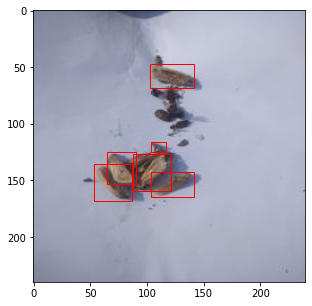

In [111]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes'].cpu()):
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target,_ = BollwormDataset(files_dir,240,240,True)[50]
print(target)
plot_img_bbox(img, target)

You can see that we are doing great till now, as the bbox is correctly placed. 

In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [ ]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

## load model

In [9]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [10]:
num_classes = 3  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Useful function for training

In [11]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = BollwormDataset(DIR_TRAIN,240,240,True,trans)
valid_dataset = BollwormDataset(DIR_TRAIN,240,240,False,trans)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [ ]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

# Training

In [19]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

In [20]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets,_ in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

Iteration #50 loss: 0.4963529706001282
Iteration #100 loss: 1.5622894763946533
Iteration #150 loss: 1.0442136526107788
Iteration #200 loss: 2.318676233291626
Iteration #250 loss: 0.45207077264785767
Iteration #300 loss: 0.5547528862953186
Iteration #350 loss: 0.975145697593689
Iteration #400 loss: 0.6096178293228149
Iteration #450 loss: 0.40734031796455383
Iteration #500 loss: 0.7133104801177979
Iteration #550 loss: 0.4471408426761627
Iteration #600 loss: 1.4828611612319946
Iteration #650 loss: 1.2812612056732178
Iteration #700 loss: 0.5768011808395386
Iteration #750 loss: 1.2028861045837402
Iteration #800 loss: 0.8894038200378418
Iteration #850 loss: 1.0782482624053955
Iteration #900 loss: 2.2124133110046387
Iteration #950 loss: 1.108360767364502
Iteration #1000 loss: 1.5485037565231323
Iteration #1050 loss: 1.206134557723999
Iteration #1100 loss: 3.693073272705078
Iteration #1150 loss: 0.9847820401191711
Iteration #1200 loss: 0.8427694439888
Iteration #1250 loss: 0.782585084438324
It

In [108]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Making predictions to submit competition submission file !

EXPECTED OUTPUT

tensor([185.7789,  12.2477, 193.6633,  23.2703])
tensor([ 55.8898,  95.4266,  73.4234, 103.1000])
tensor([ 88.2602, 121.7234, 121.8516, 153.6172])


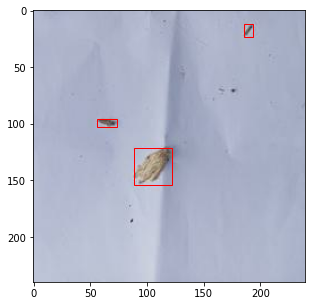

MODEL OUTPUT

tensor([185.4247,  12.7674, 194.2610,  23.4090])
tensor([110.8974, 122.3456, 115.7496, 126.3160])
tensor([ 92.6015, 136.3737,  96.3625, 141.3277])
tensor([103.9870, 138.4010, 108.4199, 143.2667])
tensor([ 92.8460, 150.0667,  97.6361, 153.7491])
tensor([ 99.7105, 128.3575, 103.1599, 132.2170])
tensor([101.0989, 147.2308, 105.2526, 151.5209])
tensor([105.0662, 126.4312, 108.9151, 130.7956])
tensor([105.7590, 133.3769, 110.1434, 138.2126])
tensor([ 97.3145, 135.2069, 100.7029, 140.8360])
tensor([ 88.9284, 142.7206,  92.3385, 148.0815])
tensor([110.9722, 129.1571, 114.8820, 135.0726])
tensor([ 56.8839,  95.2876,  72.9686, 103.3923])
tensor([163.9456,  69.1114, 168.9772,  72.2162])
tensor([106.5036, 143.4412, 111.1606, 149.1484])


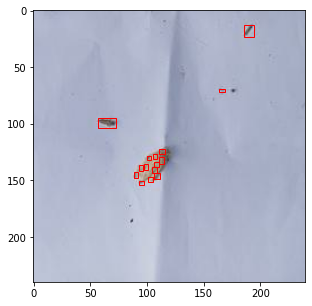

In [127]:
### pick one image from the test set
#img, target = dataset_test[5]
# put the model in evaluation mode
from torchvision import transforms as torchtrans  

train=pd.read_csv('/kaggle/input/train-csv/Train.csv')

model.eval()
cpu_device = torch.device("cpu")
imgg, targett,x= BollwormDataset(DIR_TRAIN,240,240,True,trans)[2]

with torch.no_grad():

    prediction = model([imgg.to(device)])
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(imgg), targett)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction[0], iou_thresh=0.0001)
plot_img_bbox(torch_to_pil(imgg), nms_prediction)

In [30]:
test=pd.read_csv('/kaggle/input/train-csv/Test.csv')
test['image_id_worm'][0]

'id_00332970f80fa9a47a39516d.jpg'